In [1]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from category_encoders import TargetEncoder
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/liar-dataset/train.tsv", sep="\t", header=None)
df.columns = ["id","label","statement","subjects","speaker","speaker_job","state","party",
              "barely_true_counts","false_counts","half_true_counts","mostly_true_counts",
              "pants_on_fire_counts","context"]

# Binary label
true_labels = ["true", "mostly-true", "half-true"]
df["binary_label"] = df["label"].apply(lambda x: "true" if x in true_labels else "false")

In [3]:
# Preprocess text function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", " ", text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Clean text columns
df["clean_statement"] = df["statement"].apply(preprocess)
df["clean_subjects"] = df["subjects"].fillna("").apply(preprocess)
df["clean_context"] = df["context"].fillna("").apply(preprocess)

# TF-IDF for text columns
tfidf_statement = TfidfVectorizer(max_features=12000, ngram_range=(1,3), min_df=3, max_df=0.9)
X_statement = tfidf_statement.fit_transform(df["clean_statement"])

tfidf_subjects = TfidfVectorizer(max_features=5000)
X_subjects = tfidf_subjects.fit_transform(df["clean_subjects"])

tfidf_context = TfidfVectorizer(max_features=5000)
X_context = tfidf_context.fit_transform(df["clean_context"])

# Numeric features scaled
numeric_cols = ["barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts"]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_cols].fillna(0))

# Target encoding for speaker and speaker_job
te_speaker = TargetEncoder()
df['speaker_encoded'] = te_speaker.fit_transform(df['speaker'], df['binary_label'].map({'false':0,'true':1}))

te_job = TargetEncoder()
df['speaker_job_encoded'] = te_job.fit_transform(df['speaker_job'], df['binary_label'].map({'false':0,'true':1}))


In [4]:
# One-hot encoding for state and party
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_cat = ohe.fit_transform(df[['state','party']].fillna("unknown"))

# Combine all features
import numpy as np
X_combined = hstack([X_statement, X_subjects, X_context, X_numeric, 
                     np.array(df[['speaker_encoded','speaker_job_encoded']]), X_cat])

# Labels
le = LabelEncoder()
y_numeric = le.fit_transform(df["binary_label"])

=== Logistic Regression ===
Accuracy: 0.734375
F1 Score: 0.7300915270826166
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       888
           1       0.77      0.76      0.76      1160

    accuracy                           0.73      2048
   macro avg       0.73      0.73      0.73      2048
weighted avg       0.73      0.73      0.73      2048



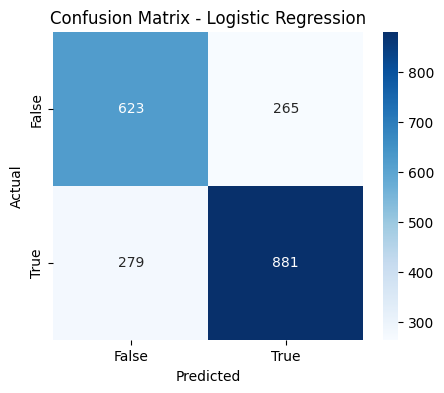

=== XGBoost ===
Accuracy: 0.74951171875
F1 Score: 0.7421958103972759
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       888
           1       0.76      0.81      0.79      1160

    accuracy                           0.75      2048
   macro avg       0.75      0.74      0.74      2048
weighted avg       0.75      0.75      0.75      2048



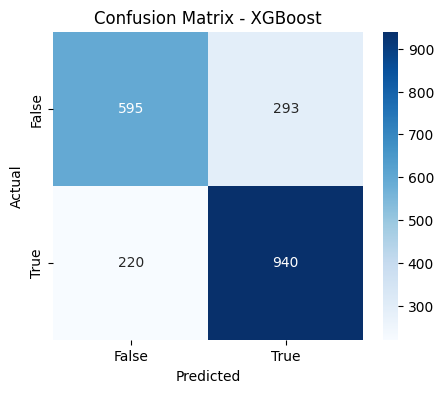

Top words predicting TRUE: ['say' 'state' 'percent' 'year' 'tax' '000' 'million' 'job' 'country'
 'american' 'people' 'obama' 'one' 'time' 'health' 'president' 'since'
 'texas' 'rate' 'every']
Top words predicting FALSE: ['say' 'state' 'obama' 'tax' 'year' 'president' 'percent' 'health' 'care'
 'people' 'job' '000' 'barack' 'would' 'bill' 'health care' 'government'
 'million' 'one' 'barack obama']
Top 20 important features (XGBoost):
11961: Importance=0.014367541298270226
3484: Importance=0.004478593356907368
11957: Importance=0.00444983784109354
6856: Importance=0.0037715064827352762
4020: Importance=0.0036749530117958784
11747: Importance=0.0036362488754093647
11026: Importance=0.0035283558536320925
11958: Importance=0.0035231958609074354
9576: Importance=0.0035189534537494183
4045: Importance=0.0034679186064749956
4238: Importance=0.0034160420764237642
1493: Importance=0.003358758520334959
64: Importance=0.0033475442323833704
10262: Importance=0.0032898036297410727
5372: Importance=

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_numeric, test_size=0.2, random_state=42)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear")
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# Evaluate models
models = {"Logistic Regression": log_pred, "XGBoost": xgb_pred}
for name, pred in models.items():
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("F1 Score:", f1_score(y_test, pred, average="macro"))
    print(classification_report(y_test, pred))
    
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False","True"], yticklabels=["False","True"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Display top TF-IDF features for TRUE and FALSE from statements
import numpy as np
feature_array = np.array(tfidf_statement.get_feature_names_out())
true_class_idx = np.where(y_numeric==1)[0]
false_class_idx = np.where(y_numeric==0)[0]
tfidf_mean_true = np.array(X_statement[true_class_idx].mean(axis=0)).flatten()
tfidf_mean_false = np.array(X_statement[false_class_idx].mean(axis=0)).flatten()

top_true_idx = tfidf_mean_true.argsort()[-20:][::-1]
top_false_idx = tfidf_mean_false.argsort()[-20:][::-1]

print("Top words predicting TRUE:", feature_array[top_true_idx])
print("Top words predicting FALSE:", feature_array[top_false_idx])

# Feature importance from XGBoost
importances = xgb.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]
print("Top 20 important features (XGBoost):")
for idx in top_idx:
    print(f"{idx}: Importance={importances[idx]}")



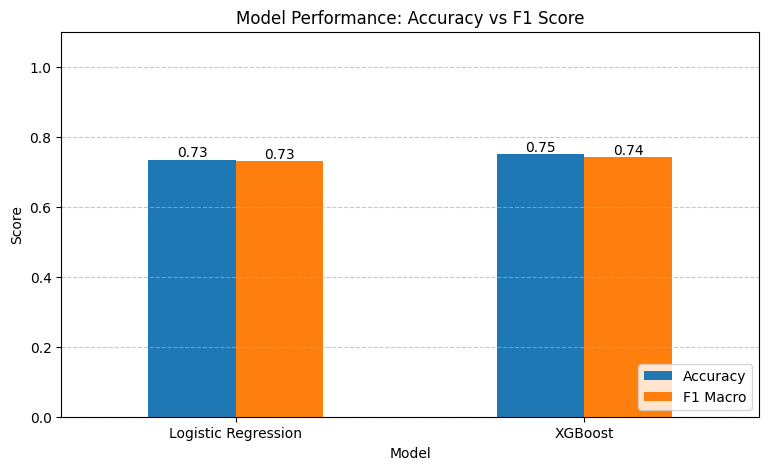

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a dataframe for plotting
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, log_pred), accuracy_score(y_test, xgb_pred)],
    'F1 Macro': [f1_score(y_test, log_pred, average="macro"), f1_score(y_test, xgb_pred, average="macro")]
})

# Plotting
ax = results_df.set_index('Model').plot(kind='bar', figsize=(9, 5), color=['#1f77b4', '#ff7f0e'])
plt.title('Model Performance: Accuracy vs F1 Score')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Add labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

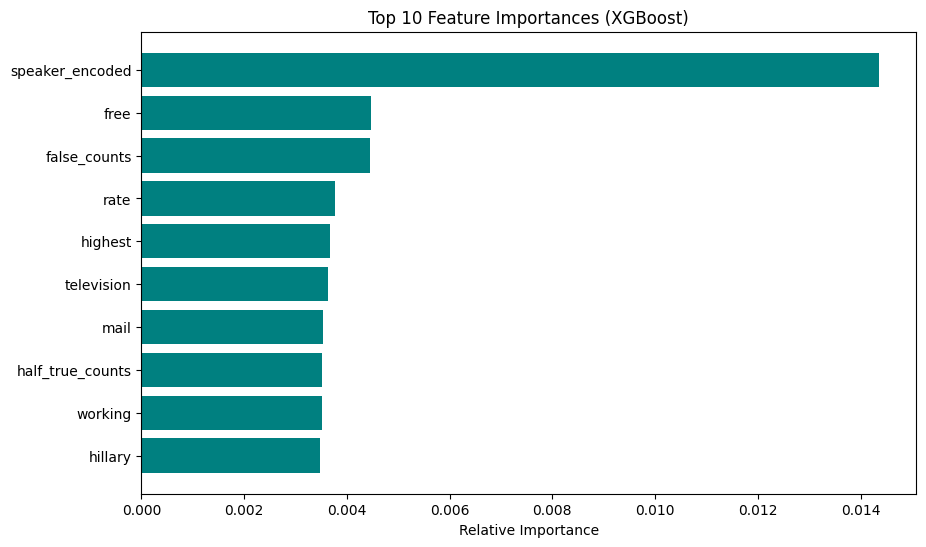

In [7]:
# 1. Gather all feature names in the exact order of hstack
names_statement = tfidf_statement.get_feature_names_out()
names_subjects = tfidf_subjects.get_feature_names_out()
names_context = tfidf_context.get_feature_names_out()
names_numeric = numeric_cols
names_speakers = ['speaker_encoded', 'speaker_job_encoded']
names_cat = ohe.get_feature_names_out()

# Combine them
all_feature_names = np.concatenate([
    names_statement, 
    names_subjects, 
    names_context, 
    names_numeric, 
    names_speakers, 
    names_cat
])

# 2. Map importance to names
importances = xgb.feature_importances_
indices = np.argsort(importances)[-10:] # Top 10

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances (XGBoost)')
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The figure layout has changed to tight


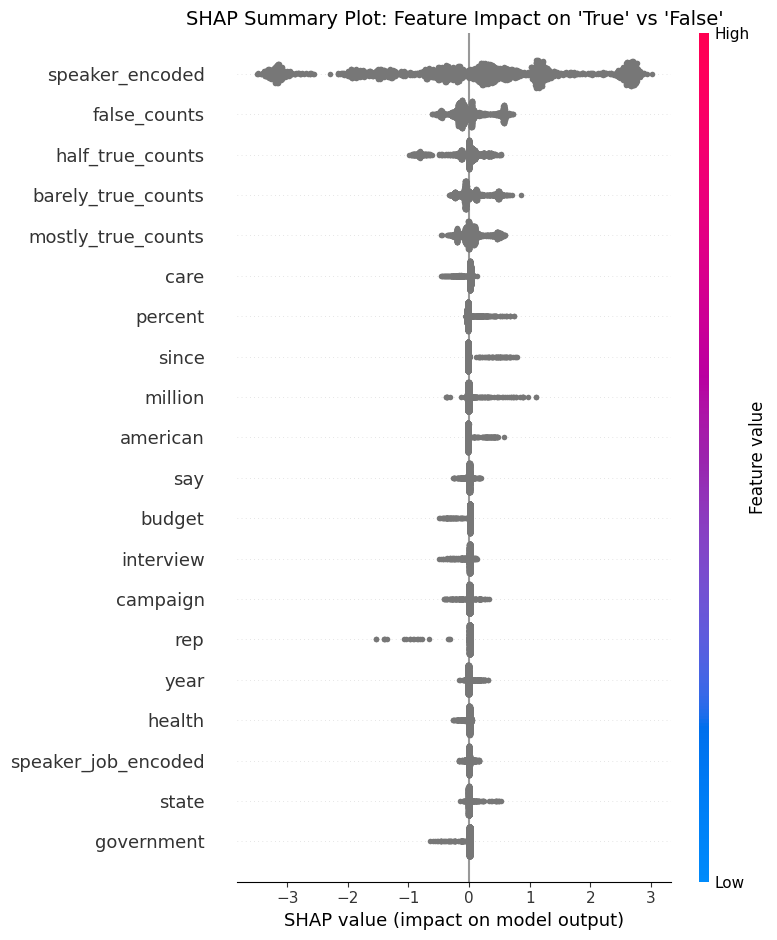

In [8]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Re-generate feature names (Crucial so the plot isn't just "Feature 0, Feature 1")
# (This logic mirrors your hstack structure)
names_statement = tfidf_statement.get_feature_names_out()
names_subjects = tfidf_subjects.get_feature_names_out()
names_context = tfidf_context.get_feature_names_out()
names_numeric = numeric_cols # ["barely_true_counts", "false_counts", etc.]
names_speakers = ['speaker_encoded', 'speaker_job_encoded']
names_cat = ohe.get_feature_names_out()

all_feature_names = np.concatenate([
    names_statement, 
    names_subjects, 
    names_context, 
    names_numeric, 
    names_speakers, 
    names_cat
])

# 2. Initialize the SHAP Explainer with your XGBoost model
# We use a subset of X_test (e.g., first 1000 rows) to speed up calculation if dataset is huge
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# 3. Create the Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=all_feature_names, show=False)
plt.title("SHAP Summary Plot: Feature Impact on 'True' vs 'False'", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# ===== DATASET OVERVIEW =====

print("Shape of dataset:", df.shape)
print("\nColumn names:", df.columns.tolist())

print("\nLabel distribution:")
print(df["binary_label"].value_counts())

print("\nSample rows:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())


Shape of dataset: (10240, 20)

Column names: ['id', 'label', 'statement', 'subjects', 'speaker', 'speaker_job', 'state', 'party', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'binary_label', 'clean_statement', 'clean_subjects', 'clean_context', 'speaker_encoded', 'speaker_job_encoded']

Label distribution:
binary_label
true     5752
false    4488
Name: count, dtype: int64

Sample rows:
           id        label                                          statement  \
0   2635.json        false  Says the Annies List political group supports ...   
1  10540.json    half-true  When did the decline of coal start? It started...   
2    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3   1123.json        false  Health care reform legislation is likely to ma...   
4   9028.json    half-true  The economic turnaround started at the end of ...   

                             subjects         speaker 

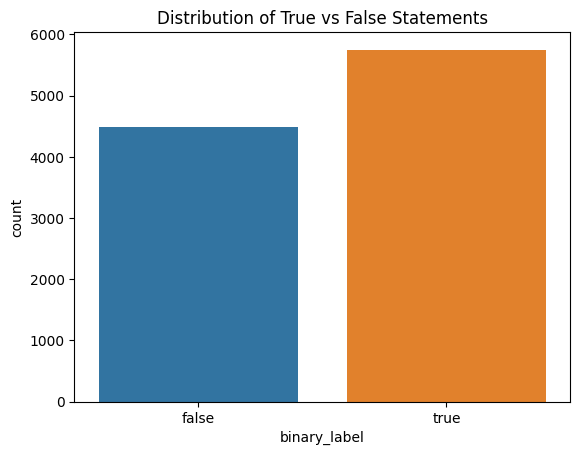

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["binary_label"])
plt.title("Distribution of True vs False Statements")
plt.show()
